In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.cluster import KMeans
import quantecon as qe
import matplotlib.pyplot as plt
import pickle
import kagglehub
from linearmodels.iv import IVGMM
from linearmodels.iv import IV2SLS
from statsmodels.api import add_constant
from statsmodels.api import OLS

In [20]:
# 2010 population + crime data
with open('df_2010_controls2_final.pkl', 'rb') as f:
    df_2010_controls2_final = pickle.load(f)

# Create a copy
df_2010_copy = df_2010_controls2_final.copy()

In [21]:
# Example: Calculate weights based on total_pop_1860
df_2010_copy['weight_1860'] = df_2010_copy['total_pop_1860'] / df_2010_copy['total_pop_1860'].sum()

# Example: Calculate weights based on total_pop_2010
df_2010_copy['weight_2010'] = df_2010_copy['total_pop_2010'] / df_2010_copy['total_pop_2010'].sum()

# Check the weights
print(df_2010_copy[['total_pop_1860', 'total_pop_2010', 'weight_1860', 'weight_2010']])

     total_pop_1860  total_pop_2010  weight_1860  weight_2010
0          363707.0           54571     0.037416     0.006646
1          293900.0          182265     0.030235     0.022198
2          397008.0           27457     0.040842     0.003344
3          138741.0           22915     0.014273     0.002791
4          376181.0           57322     0.038699     0.006981
..              ...             ...          ...          ...
130          1844.0           36312     0.000190     0.004422
131          8485.0          102599     0.000873     0.012495
132          1786.0            9255     0.000184     0.001127
133          5845.0            9563     0.000601     0.001165
134          2278.0           21679     0.000234     0.002640

[126 rows x 4 columns]


In [22]:
def weighted_bootstrap(df, weight_column, n_samples):
    """
    Perform weighted bootstrap resampling.

    Parameters:
    - df: DataFrame to bootstrap.
    - weight_column: Column name containing the weights.
    - n_samples: Number of rows to sample in each bootstrap iteration.

    Returns:
    - Bootstrapped DataFrame.
    """
    # Ensure weights are normalized
    weights = df[weight_column]
    weights /= weights.sum()  # Normalize weights to sum to 1

    # Perform sampling
    bootstrapped_indices = np.random.choice(df.index, size=n_samples, replace=True, p=weights)
    return df.loc[bootstrapped_indices]


In [23]:
# Number of bootstrap iterations
n_bootstrap_iterations = 1000

# Store bootstrap results
bootstrap_results = []

for i in range(n_bootstrap_iterations):
    # Generate a bootstrap sample
    sample = weighted_bootstrap(df_2010_copy, 'weight_1860', len(df_2010_copy))
    
    # Example: Run a regression or calculate statistics on the bootstrap sample
    # For example, calculate the mean population:
    mean_pop_1860 = sample['total_pop_1860'].mean()
    bootstrap_results.append(mean_pop_1860)

# Convert results to a DataFrame for analysis
bootstrap_results_df = pd.DataFrame(bootstrap_results, columns=['mean_pop_1860'])

# Check the distribution of bootstrapped statistics
print(bootstrap_results_df.describe())


       mean_pop_1860
count    1000.000000
mean   170371.140625
std     10916.592773
min    138151.203125
25%    163183.027344
50%    169993.328125
75%    177753.093750
max    220222.953125


In [24]:
df_2010_copy['total_pop_1860'].describe()

count       126.000000
mean      77148.117188
std       84761.898438
min        1786.000000
25%       13929.500000
50%       61007.500000
75%       87732.000000
max      397008.000000
Name: total_pop_1860, dtype: float64

In [25]:
# Notice the bootstrapped distribution is significantly different from our original sample distribution. 
# The bootstrap may be over-inflating counties with larger populations. Lets check this

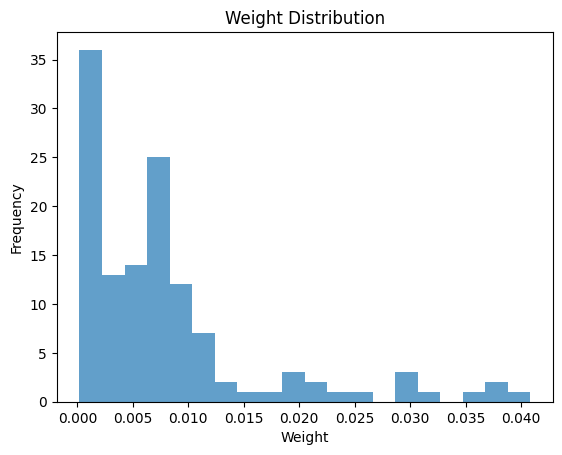

    total_pop_1860  weight_1860
2         397008.0     0.040842
4         376181.0     0.038699
0         363707.0     0.037416
8         355106.0     0.036531
12        306694.0     0.031551


In [26]:
# Check the weight distribution
plt.hist(df_2010_copy['weight_1860'], bins=20, alpha=0.7)
plt.title('Weight Distribution')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

# Inspect counties with the largest weights
print(df_2010_copy[['total_pop_1860', 'weight_1860']].sort_values(by='weight_1860', ascending=False).head())

# The weights appear to be heavily skewed. Weights are already normalized.

***Re-calculate the weight distribution based on log population***


In [27]:
# Re-calculate the weight distribution based on log population
df_2010_copy['log_weight_1860'] = df_2010_copy['log_pop_1860'] / df_2010_copy['log_pop_1860'].sum()

# Example: Calculate weights based on total_pop_2010
#df_2010_copy['weight_2010'] = df_2010_copy['total_pop_2010'] / df_2010_copy['total_pop_2010'].sum()

# Check the weights
#print(df_2010_copy[['total_pop_1860', 'total_pop_2010', 'weight_1860', 'weight_2010']])
print(df_2010_copy[['log_pop_1860', 'log_weight_1860']])

     log_pop_1860  log_weight_1860
0       12.804104         0.009588
1       12.590995         0.009428
2       12.891712         0.009654
3       11.840364         0.008866
4       12.837826         0.009613
..            ...              ...
130      7.519692         0.005631
131      9.046055         0.006774
132      7.487734         0.005607
133      8.673342         0.006495
134      7.731053         0.005789

[126 rows x 2 columns]


In [28]:
# Re-calculate the weight distribution based on log population
df_2010_copy['log_weight_1860'] = df_2010_copy['log_pop_1860'] / df_2010_copy['log_pop_1860'].sum()

# Verify weights
assert np.isclose(df_2010_copy['log_weight_1860'].sum(), 1.0), "Weights must sum to 1."
assert (df_2010_copy['log_weight_1860'] >= 0).all(), "All weights must be non-negative."

In [29]:
# Weighted bootstrap function
def weighted_bootstrap(df, weight_column, n_samples):
    weights = df[weight_column].values
    weights /= weights.sum()  # Ensure weights sum to 1
    bootstrapped_indices = np.random.choice(
        df.index,
        size=n_samples,
        replace=True,
        p=weights
    )
    return df.loc[bootstrapped_indices]

# Number of bootstrap iterations
n_bootstrap_iterations = 1000
bootstrap_results = np.empty(n_bootstrap_iterations)

In [30]:
# Perform bootstrap sampling
for i in range(n_bootstrap_iterations):
    sample = weighted_bootstrap(df_2010_copy, 'log_weight_1860', len(df_2010_copy))
    mean_log_pop_1860 = sample['log_pop_1860'].mean()
    bootstrap_results[i] = mean_log_pop_1860

# Convert results to DataFrame for analysis
bootstrap_results_df = pd.DataFrame(bootstrap_results, columns=['mean_log_pop_1860'])

# Summary of bootstrap results
print(bootstrap_results_df.describe())

       mean_log_pop_1860
count        1000.000000
mean           10.762431
std             0.109312
min            10.313689
25%            10.694770
50%            10.769338
75%            10.836694
max            11.091194


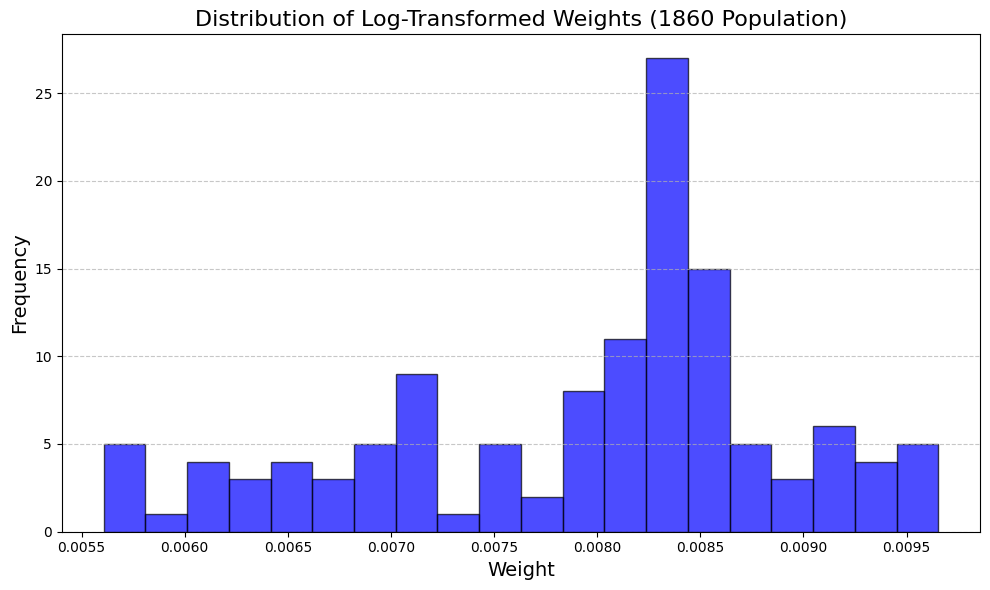

In [31]:
# Plot the weight distribution
plt.figure(figsize=(10, 6))
plt.hist(df_2010_copy['log_weight_1860'], bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Log-Transformed Weights (1860 Population)', fontsize=16)
plt.xlabel('Weight', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

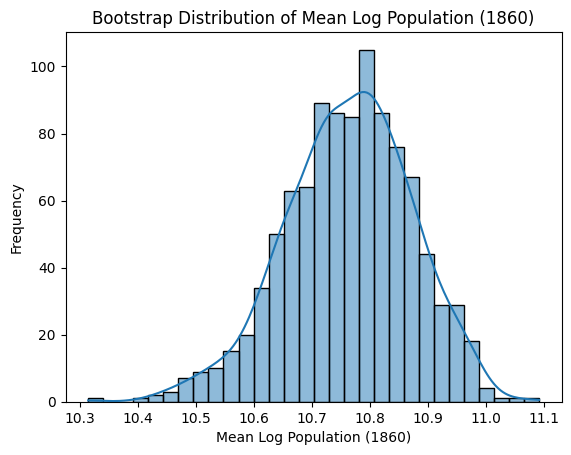

In [32]:
# Visualize the bootstrap distribution
sns.histplot(bootstrap_results, bins=30, kde=True)
plt.title('Bootstrap Distribution of Mean Log Population (1860)')
plt.xlabel('Mean Log Population (1860)')
plt.ylabel('Frequency')
plt.show()

In [33]:
# Compare to weighted mean
weighted_mean = (df_2010_copy['log_pop_1860'] * df_2010_copy['log_weight_1860']).sum()
print("Weighted Mean (Original Data):", weighted_mean)
print("Bootstrap Mean:", np.mean(bootstrap_results))

Weighted Mean (Original Data): 10.763226
Bootstrap Mean: 10.76243141937256


***Weighted Bootstrap for IV***

In [34]:
# Define the number of bootstrap iterations
n_bootstrap_iterations = 1000

# Store bootstrap coefficient estimates
bootstrap_coefficients = []

# Weighted bootstrap function
def weighted_bootstrap_iv(df, weight_column, n_samples):
    weights = df[weight_column].values
    weights /= weights.sum()  # Normalize weights
    bootstrapped_indices = np.random.choice(
        df.index, size=n_samples, replace=True, p=weights
    )
    return df.loc[bootstrapped_indices]

***Weighted boostrap - murder rate 3 controls***

In [43]:

# Number of bootstrap iterations
n_bootstrap_iterations = 1000

# Initialize lists to store bootstrap results for each regression
bootstrap_coefficients_1 = []
bootstrap_coefficients_2 = []
bootstrap_coefficients_3 = []

# Perform the weighted bootstrap with log weights
for i in range(n_bootstrap_iterations):
    # Generate a bootstrap sample using log weights
    sample = weighted_bootstrap(df_2010_copy, 'log_weight_1860', len(df_2010_copy))
    
    # 1. Regression with 1 Control
    y_first_stage_1 = sample['gini_stata']
    X_first_stage_1 = sample[['log_slave', 'pop_density_1860']]
    X_first_stage_1 = sm.add_constant(X_first_stage_1)
    model_first_stage_1 = sm.OLS(y_first_stage_1, X_first_stage_1).fit()
    fitted_gini_stata_1 = model_first_stage_1.predict(X_first_stage_1)

    y_second_stage_1 = sample['log_murder_rate']
    X_second_stage_1 = sample[['pop_density_2010']]
    X_second_stage_1 = sm.add_constant(X_second_stage_1)

    iv_model_1 = IV2SLS(
        dependent=y_second_stage_1,
        exog=X_second_stage_1,
        endog=sample['gini_stata'],
        instruments=sample[['log_slave']]
    )
    iv_results_1 = iv_model_1.fit()
    bootstrap_coefficients_1.append(iv_results_1.params['gini_stata'])

    # 2. Regression with 2 Controls
    y_first_stage_2 = sample['gini_stata']
    X_first_stage_2 = sample[['log_slave', 'pop_density_1860', 'total_males_15_29_1860']]
    X_first_stage_2 = sm.add_constant(X_first_stage_2)
    model_first_stage_2 = sm.OLS(y_first_stage_2, X_first_stage_2).fit()
    fitted_gini_stata_2 = model_first_stage_2.predict(X_first_stage_2)

    y_second_stage_2 = sample['log_murder_rate']
    X_second_stage_2 = sample[['pop_density_2010', 'total_males_15_29_2010']]
    X_second_stage_2 = sm.add_constant(X_second_stage_2)

    iv_model_2 = IV2SLS(
        dependent=y_second_stage_2,
        exog=X_second_stage_2,
        endog=sample['gini_stata'],
        instruments=sample[['log_slave']]
    )
    iv_results_2 = iv_model_2.fit()
    bootstrap_coefficients_2.append(iv_results_2.params['gini_stata'])

    # 3. Regression with 3 Controls
    y_first_stage_3 = sample['gini_stata']
    X_first_stage_3 = sample[['log_slave', 'pop_density_1860', 'total_males_15_29_1860', 'ag_gdp_1860']]
    X_first_stage_3 = sm.add_constant(X_first_stage_3)
    model_first_stage_3 = sm.OLS(y_first_stage_3, X_first_stage_3).fit()
    fitted_gini_stata_3 = model_first_stage_3.predict(X_first_stage_3)

    y_second_stage_3 = sample['log_murder_rate']
    X_second_stage_3 = sample[['pop_density_2010', 'total_males_15_29_2010', 'gdp_2010']]
    X_second_stage_3 = sm.add_constant(X_second_stage_3)

    iv_model_3 = IV2SLS(
        dependent=y_second_stage_3,
        exog=X_second_stage_3,
        endog=sample['gini_stata'],
        instruments=sample[['log_slave']]
    )
    iv_results_3 = iv_model_3.fit()
    bootstrap_coefficients_3.append(iv_results_3.params['gini_stata'])

# Convert bootstrap results to DataFrames
bootstrap_results_1 = pd.DataFrame(bootstrap_coefficients_1, columns=['Coefficient (1 Control)'])
bootstrap_results_2 = pd.DataFrame(bootstrap_coefficients_2, columns=['Coefficient (2 Controls)'])
bootstrap_results_3 = pd.DataFrame(bootstrap_coefficients_3, columns=['Coefficient (3 Controls)'])

# Print summary statistics
print("Summary Statistics (1 Control):")
print(bootstrap_results_1.describe())

print("\nSummary Statistics (2 Controls):")
print(bootstrap_results_2.describe())

print("\nSummary Statistics (3 Controls):")
print(bootstrap_results_3.describe())


Summary Statistics (1 Control):
       Coefficient (1 Control)
count              1000.000000
mean                  3.664167
std                   1.164599
min                   0.325347
25%                   2.844687
50%                   3.591629
75%                   4.349069
max                   9.481029

Summary Statistics (2 Controls):
       Coefficient (2 Controls)
count               1000.000000
mean                   4.201412
std                    1.263366
min                    0.442214
25%                    3.349552
50%                    4.130394
75%                    4.923760
max                   11.544753

Summary Statistics (3 Controls):
       Coefficient (3 Controls)
count               1000.000000
mean                   4.202382
std                    1.263401
min                    0.379424
25%                    3.355987
50%                    4.121454
75%                    4.927060
max                   11.127598


***Weighted boostrap - mtv theft rate 3 controls***

In [44]:
# Number of bootstrap iterations
n_bootstrap_iterations = 1000

# Initialize lists to store bootstrap results for each regression
bootstrap_coefficients_1 = []
bootstrap_coefficients_2 = []
bootstrap_coefficients_3 = []

# Perform the weighted bootstrap with log weights
for i in range(n_bootstrap_iterations):
    # Generate a bootstrap sample using log weights
    sample = weighted_bootstrap(df_2010_copy, 'log_weight_1860', len(df_2010_copy))
    
    # 1. Regression with 1 Control
    y_first_stage_1 = sample['gini_stata']
    X_first_stage_1 = sample[['log_slave', 'pop_density_1860']]
    X_first_stage_1 = sm.add_constant(X_first_stage_1)
    model_first_stage_1 = sm.OLS(y_first_stage_1, X_first_stage_1).fit()
    fitted_gini_stata_1 = model_first_stage_1.predict(X_first_stage_1)

    y_second_stage_1 = sample['log_mtv_theft_rate']
    X_second_stage_1 = sample[['pop_density_2010']]
    X_second_stage_1 = sm.add_constant(X_second_stage_1)

    iv_model_1 = IV2SLS(
        dependent=y_second_stage_1,
        exog=X_second_stage_1,
        endog=sample['gini_stata'],
        instruments=sample[['log_slave']]
    )
    iv_results_1 = iv_model_1.fit()
    bootstrap_coefficients_1.append(iv_results_1.params['gini_stata'])

    # 2. Regression with 2 Controls
    y_first_stage_2 = sample['gini_stata']
    X_first_stage_2 = sample[['log_slave', 'pop_density_1860', 'total_males_15_29_1860']]
    X_first_stage_2 = sm.add_constant(X_first_stage_2)
    model_first_stage_2 = sm.OLS(y_first_stage_2, X_first_stage_2).fit()
    fitted_gini_stata_2 = model_first_stage_2.predict(X_first_stage_2)

    y_second_stage_2 = sample['log_mtv_theft_rate']
    X_second_stage_2 = sample[['pop_density_2010', 'total_males_15_29_2010']]
    X_second_stage_2 = sm.add_constant(X_second_stage_2)

    iv_model_2 = IV2SLS(
        dependent=y_second_stage_2,
        exog=X_second_stage_2,
        endog=sample['gini_stata'],
        instruments=sample[['log_slave']]
    )
    iv_results_2 = iv_model_2.fit()
    bootstrap_coefficients_2.append(iv_results_2.params['gini_stata'])

    # 3. Regression with 3 Controls
    y_first_stage_3 = sample['gini_stata']
    X_first_stage_3 = sample[['log_slave', 'pop_density_1860', 'total_males_15_29_1860', 'ag_gdp_1860']]
    X_first_stage_3 = sm.add_constant(X_first_stage_3)
    model_first_stage_3 = sm.OLS(y_first_stage_3, X_first_stage_3).fit()
    fitted_gini_stata_3 = model_first_stage_3.predict(X_first_stage_3)

    y_second_stage_3 = sample['log_mtv_theft_rate']
    X_second_stage_3 = sample[['pop_density_2010', 'total_males_15_29_2010', 'gdp_2010']]
    X_second_stage_3 = sm.add_constant(X_second_stage_3)

    iv_model_3 = IV2SLS(
        dependent=y_second_stage_3,
        exog=X_second_stage_3,
        endog=sample['gini_stata'],
        instruments=sample[['log_slave']]
    )
    iv_results_3 = iv_model_3.fit()
    bootstrap_coefficients_3.append(iv_results_3.params['gini_stata'])

# Convert bootstrap results to DataFrames
bootstrap_results_1 = pd.DataFrame(bootstrap_coefficients_1, columns=['Coefficient (1 Control)'])
bootstrap_results_2 = pd.DataFrame(bootstrap_coefficients_2, columns=['Coefficient (2 Controls)'])
bootstrap_results_3 = pd.DataFrame(bootstrap_coefficients_3, columns=['Coefficient (3 Controls)'])

# Print summary statistics
print("Summary Statistics (1 Control):")
print(bootstrap_results_1.describe())

print("\nSummary Statistics (2 Controls):")
print(bootstrap_results_2.describe())

print("\nSummary Statistics (3 Controls):")
print(bootstrap_results_3.describe())


Summary Statistics (1 Control):
       Coefficient (1 Control)
count              1000.000000
mean                  1.067433
std                   1.484613
min                  -3.803819
25%                   0.120015
50%                   1.030305
75%                   2.044599
max                   6.224443

Summary Statistics (2 Controls):
       Coefficient (2 Controls)
count               1000.000000
mean                   1.657588
std                    1.601199
min                   -3.559225
25%                    0.603947
50%                    1.594862
75%                    2.695521
max                    7.769796

Summary Statistics (3 Controls):
       Coefficient (3 Controls)
count               1000.000000
mean                   1.675050
std                    1.602789
min                   -3.462847
25%                    0.610644
50%                    1.600799
75%                    2.683669
max                    7.900071


***Weighted boostrap - crime rate 3 controls***

In [45]:
# Number of bootstrap iterations
n_bootstrap_iterations = 1000

# Initialize lists to store bootstrap results for each regression
bootstrap_coefficients_1 = []
bootstrap_coefficients_2 = []
bootstrap_coefficients_3 = []

# Perform the weighted bootstrap with log weights
for i in range(n_bootstrap_iterations):
    # Generate a bootstrap sample using log weights
    sample = weighted_bootstrap(df_2010_copy, 'log_weight_1860', len(df_2010_copy))
    
    # 1. Regression with 1 Control
    y_first_stage_1 = sample['gini_stata']
    X_first_stage_1 = sample[['log_slave', 'pop_density_1860']]
    X_first_stage_1 = sm.add_constant(X_first_stage_1)
    model_first_stage_1 = sm.OLS(y_first_stage_1, X_first_stage_1).fit()
    fitted_gini_stata_1 = model_first_stage_1.predict(X_first_stage_1)

    y_second_stage_1 = sample['log_crime_rate']
    X_second_stage_1 = sample[['pop_density_2010']]
    X_second_stage_1 = sm.add_constant(X_second_stage_1)

    iv_model_1 = IV2SLS(
        dependent=y_second_stage_1,
        exog=X_second_stage_1,
        endog=sample['gini_stata'],
        instruments=sample[['log_slave']]
    )
    iv_results_1 = iv_model_1.fit()
    bootstrap_coefficients_1.append(iv_results_1.params['gini_stata'])

    # 2. Regression with 2 Controls
    y_first_stage_2 = sample['gini_stata']
    X_first_stage_2 = sample[['log_slave', 'pop_density_1860', 'total_males_15_29_1860']]
    X_first_stage_2 = sm.add_constant(X_first_stage_2)
    model_first_stage_2 = sm.OLS(y_first_stage_2, X_first_stage_2).fit()
    fitted_gini_stata_2 = model_first_stage_2.predict(X_first_stage_2)

    y_second_stage_2 = sample['log_crime_rate']
    X_second_stage_2 = sample[['pop_density_2010', 'total_males_15_29_2010']]
    X_second_stage_2 = sm.add_constant(X_second_stage_2)

    iv_model_2 = IV2SLS(
        dependent=y_second_stage_2,
        exog=X_second_stage_2,
        endog=sample['gini_stata'],
        instruments=sample[['log_slave']]
    )
    iv_results_2 = iv_model_2.fit()
    bootstrap_coefficients_2.append(iv_results_2.params['gini_stata'])

    # 3. Regression with 3 Controls
    y_first_stage_3 = sample['gini_stata']
    X_first_stage_3 = sample[['log_slave', 'pop_density_1860', 'total_males_15_29_1860', 'ag_gdp_1860']]
    X_first_stage_3 = sm.add_constant(X_first_stage_3)
    model_first_stage_3 = sm.OLS(y_first_stage_3, X_first_stage_3).fit()
    fitted_gini_stata_3 = model_first_stage_3.predict(X_first_stage_3)

    y_second_stage_3 = sample['log_crime_rate']
    X_second_stage_3 = sample[['pop_density_2010', 'total_males_15_29_2010', 'gdp_2010']]
    X_second_stage_3 = sm.add_constant(X_second_stage_3)

    iv_model_3 = IV2SLS(
        dependent=y_second_stage_3,
        exog=X_second_stage_3,
        endog=sample['gini_stata'],
        instruments=sample[['log_slave']]
    )
    iv_results_3 = iv_model_3.fit()
    bootstrap_coefficients_3.append(iv_results_3.params['gini_stata'])

# Convert bootstrap results to DataFrames
bootstrap_results_1 = pd.DataFrame(bootstrap_coefficients_1, columns=['Coefficient (1 Control)'])
bootstrap_results_2 = pd.DataFrame(bootstrap_coefficients_2, columns=['Coefficient (2 Controls)'])
bootstrap_results_3 = pd.DataFrame(bootstrap_coefficients_3, columns=['Coefficient (3 Controls)'])

# Print summary statistics
print("Summary Statistics (1 Control):")
print(bootstrap_results_1.describe())

print("\nSummary Statistics (2 Controls):")
print(bootstrap_results_2.describe())

print("\nSummary Statistics (3 Controls):")
print(bootstrap_results_3.describe())


Summary Statistics (1 Control):
       Coefficient (1 Control)
count              1000.000000
mean                 -0.411278
std                   0.756934
min                  -2.995869
25%                  -0.874609
50%                  -0.388166
75%                   0.077688
max                   2.347225

Summary Statistics (2 Controls):
       Coefficient (2 Controls)
count               1000.000000
mean                  -0.040335
std                    0.746072
min                   -2.198247
25%                   -0.518186
50%                   -0.021926
75%                    0.431451
max                    2.931831

Summary Statistics (3 Controls):
       Coefficient (3 Controls)
count               1000.000000
mean                  -0.065329
std                    0.747864
min                   -2.245805
25%                   -0.555853
50%                   -0.045206
75%                    0.413177
max                    2.928620


***1st stage weighted bootstrap regressions***

In [46]:
# Number of bootstrap iterations
n_bootstrap_iterations = 1000

# Initialize lists to store bootstrap results for each regression
bootstrap_coefficients_1 = []
bootstrap_coefficients_2 = []
bootstrap_coefficients_3 = []

# Perform the weighted bootstrap for the first stage
for i in range(n_bootstrap_iterations):
    # Generate a bootstrap sample using log weights
    sample = weighted_bootstrap(df_2010_copy, 'log_weight_1860', len(df_2010_copy))
    
    # 1. First Stage with 1 Control
    y_first_stage_1 = sample['gini_stata']
    X_first_stage_1 = sample[['log_slave', 'pop_density_1860']]
    X_first_stage_1 = sm.add_constant(X_first_stage_1)
    model_first_stage_1 = sm.OLS(y_first_stage_1, X_first_stage_1).fit()
    bootstrap_coefficients_1.append(model_first_stage_1.params['log_slave'])

    # 2. First Stage with 2 Controls
    y_first_stage_2 = sample['gini_stata']
    X_first_stage_2 = sample[['log_slave', 'pop_density_1860', 'total_males_15_29_1860']]
    X_first_stage_2 = sm.add_constant(X_first_stage_2)
    model_first_stage_2 = sm.OLS(y_first_stage_2, X_first_stage_2).fit()
    bootstrap_coefficients_2.append(model_first_stage_2.params['log_slave'])

    # 3. First Stage with 3 Controls
    y_first_stage_3 = sample['gini_stata']
    X_first_stage_3 = sample[['log_slave', 'pop_density_1860', 'total_males_15_29_1860', 'ag_gdp_1860']]
    X_first_stage_3 = sm.add_constant(X_first_stage_3)
    model_first_stage_3 = sm.OLS(y_first_stage_3, X_first_stage_3).fit()
    bootstrap_coefficients_3.append(model_first_stage_3.params['log_slave'])

# Convert bootstrap results to DataFrames
bootstrap_results_1 = pd.DataFrame(bootstrap_coefficients_1, columns=['Coefficient (1 Control)'])
bootstrap_results_2 = pd.DataFrame(bootstrap_coefficients_2, columns=['Coefficient (2 Controls)'])
bootstrap_results_3 = pd.DataFrame(bootstrap_coefficients_3, columns=['Coefficient (3 Controls)'])

# Print summary statistics
print("Summary Statistics (1 Control):")
print(bootstrap_results_1.describe())

print("\nSummary Statistics (2 Controls):")
print(bootstrap_results_2.describe())

print("\nSummary Statistics (3 Controls):")
print(bootstrap_results_3.describe())

Summary Statistics (1 Control):
       Coefficient (1 Control)
count              1000.000000
mean                  0.063845
std                   0.010274
min                   0.033586
25%                   0.057066
50%                   0.063597
75%                   0.070251
max                   0.103565

Summary Statistics (2 Controls):
       Coefficient (2 Controls)
count               1000.000000
mean                   0.058928
std                    0.010527
min                    0.027167
25%                    0.052014
50%                    0.058707
75%                    0.065458
max                    0.100312

Summary Statistics (3 Controls):
       Coefficient (3 Controls)
count               1000.000000
mean                   0.059747
std                    0.016195
min                    0.003893
25%                    0.048666
50%                    0.060572
75%                    0.071017
max                    0.117231
